# Generating level 2 data

This is an example of how to use the program generate_level2.py

There are 5 steps:

1. Read the level 2 Stokes data (reduced although could be any other)
2. Calculate the wavelength axis from the header
3. Invert the data
4. Store the results

Look into ``generate_level2()`` for getting information about usage and options.

In [1]:
# Loading libraries

import sys

sys.path.append('../../../../sophi_fdt_dpp/')  
import matplotlib.pyplot as plt
import numpy as np

import sophi_fdt_dpp as fdt

### Reading level 2

For reading the data use: ` fits_get() `

Remember to set `scale=False` for reading level2

In [2]:
data_dir = './test_data/level2/'
#solo_L2_phi-fdt-stokes_20220308T070009_Vv01_0243080501.fits.gz
list_of_files = fdt.list_fits(inpath = data_dir,contain='stokes',remove_dir=True)
stokes,header = fdt.fits_get(data_dir+list_of_files[0],scale=False)

In [3]:
plt.imshow(stokes[0,0,:,:],cmap='Greys_r')
plt.colorbar()

### Extract wavelength axis from header

Extract the wavelength axis from the header using: ` fits_get_sampling() `

In [17]:
wave_axis,voltagesData,tunning_constant,cpos,ref_wavelength = fdt.fits_get_sampling(data_dir+list_of_files[0]) 

print('wave_axis (angstrom)= ', wave_axis)
print('wave_axis (volts) = ', voltagesData)
print('tunning_constant (A/V)= ', tunning_constant)
print('tunning_constant (V/A)= ', 1./tunning_constant)
print('Continuum position = ', 'red' if cpos[1] == 0 else 'blue')
print('reference wavelength = ', ref_wavelength) 

-- Obtaining sampling information from......./test_data/level2/solo_L2_phi-fdt-stokes_20220308T070009_V04_0243080501.fits.gz
continuum was taken in the RED and stored in the RED
wave_axis (angstrom)=  [6172.9524622 6173.0220196 6173.091577  6173.161837  6173.2299892
 6173.3877229]
wave_axis (volts) =  [-1106.  -908.  -710.  -510.  -316.   133.]
tunning_constant (A/V)=  0.0003513
tunning_constant (V/A)=  2846.569883290635
Continuum position =  red
reference wavelength =  6173.341


In [22]:
diff = voltagesData - np.roll(voltagesData,1)
value = np.argmax(np.abs(diff))


In [26]:
voltagesData

array([-1106.,  -908.,  -710.,  -510.,  -316.,   133.])

In [25]:
print(np.abs((voltagesData[0] - voltagesData[1])))
print(np.abs((voltagesData[-1] - voltagesData[-2])))

198.0
449.0


In [ ]:
with pyfits.open(file) as hdu_list:
    header = hdu_list[fg_head].data


In [11]:
print(wave_axis-ref_wavelength)

[-0.3885378 -0.3189804 -0.249423  -0.179163  -0.1110108  0.0467229]


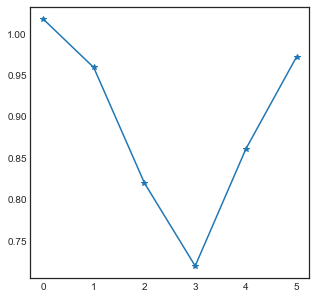

In [5]:
plt.plot(stokes[:,0,750,750],'-*')

In [9]:
test(wave_axis,ref_wavelength)

[-0.3885378 -0.3189804 -0.249423  -0.179163  -0.1110108  0.0467229] 5 [6172.9057393 6172.9752967 6173.0448541 6173.1151141 6173.1832663
 6173.341    ]


In [12]:
line_center = 3 if np.abs(wave_axis[0] - wave_axis[1]) > np.abs(wave_axis[4] - wave_axis[5]) else 2
shift_w = wave_axis[line_center] - ref_wavelength
wave_axis = wave_axis - shift_w


In [16]:
print( np.abs(wave_axis[0] - wave_axis[1]) , np.abs(wave_axis[4] - wave_axis[5] ) )


0.06955740000012156 0.15773369999988063


In [8]:
def test(w,ref_wavelength):
    diff = (w - ref_wavelength)
    index = np.argmin(np.abs(diff))
    shift_w = w[index] - ref_wavelength
    w = w - shift_w
    print(diff,index,w)

The continium is ALWAYS in the blue for the RTE

### Invert Stokes data

Now the RTE can be run on the Stokes data using: ` generate_level2() `

You need to provided the kind of inversion `rte` and some other parameters like the inversion code (cmilos or pmilos).
Options can be found in phi_rte.py in the documentation.

The most important ones are:

- RTE_code = cmilos o pmilos. In case of cmilos the temp_dir option can be set for selecting a temporary directory. Defaults to 'pmilos'
- options = ME inversion options
- weight = Stokes profile weights in the inversion. 
- initial_model = Initial ME model

In [6]:
rte_mode = 'CE'
#this is the most basic form
init_model = np.array([100,20,150,5,0.09,0.13,.01,.3,.7])
weight = np.array([1.,4.,5.4,4.1])
ce = fdt.generate_level2(stokes,wave_axis,rte_mode,center_line=True)

Centering...
   It is assumed the wavelength is given by the header info 
         wave axis:  [6173.2018852 6173.2714426 6173.341     6173.41126   6173.4794122
 6173.6371459]
         wave axis (step):   [-139.1148  -69.5574    0.       70.26    138.4122  296.1459]
         reference wavelength:   6173.341
-------------------------------------------------------------- 
  cmilos version: CMILOS v0.91 (July - 2021) 
-------------------------------------------------------------- 
No input options. Setting for PHI only.
RTE_MODE  CE
options:  [ 6. 30.  2.  0.  0.  0.  0.]
Using PMILOS version
   input shape in phi_rte:  (6, 4, 1536, 1536)
   reshaping into:  (6, 4, 2359296)
   reshaping data. New data shape (2359296, 4, 6) should be (y * x,pol,wave) for C
Entering pmilos
('input_data shape: ', 2359296, 4, 6)
('------ flattened: ', (56623104,))
Options: 
[ 6 30  2  0  0  0  0]
Weights: 
[ 1. 10. 10.  4.]
Initial Model: 
[4.0e+02 3.0e+01 1.2e+02 3.0e+00 2.5e-02 1.0e+00 1.0e-02 1.5e-01 8.5e-

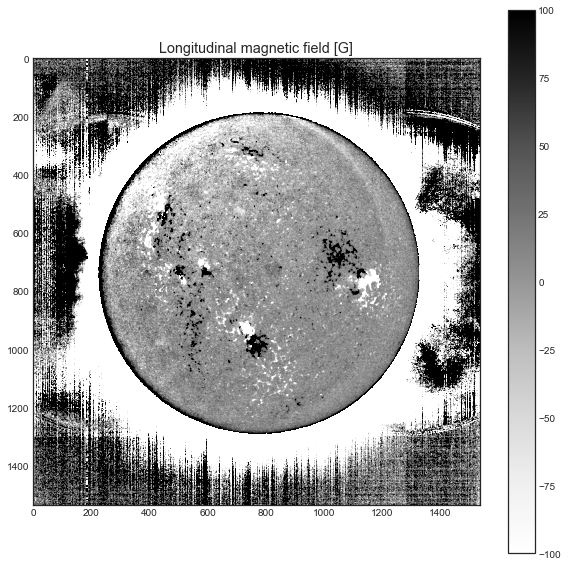

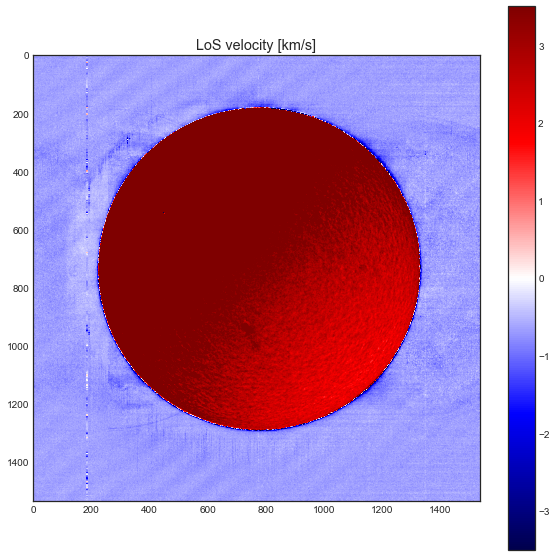

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(ce[2,:,:]*np.cos(ce[3,:,:]*np.pi/180.),vmin=-100,vmax=100)
plt.title('Longitudinal magnetic field [G]')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(ce[8,:,:],vmin=-3.5,vmax=3.5,cmap='seismic')
plt.title('LoS velocity [km/s]')
plt.colorbar()
plt.show()

In [31]:
rte_mode = 'CE+RTE'
#this is the most basic form
init_model = np.array([100,20,150,5,0.09,0.13,.01,.3,.7])
weight = np.array([1.,4.,5.4,4.1])
weight = np.array([1.,1.,1.,1.])

results = fdt.generate_level2(stokes[:,:,200:1400,200:1400],wave_axis,rte_mode,weight = weight, initial_model=init_model,center_line=True)


Centering...
   It is assumed the wavelength is given by the header info 
         wave axis:  [6173.6371459 6173.2018852 6173.2714426 6173.341     6173.41126
 6173.4794122]
         wave axis (step):   [ 296.1459 -139.1148  -69.5574    0.       70.26    138.4122]
         reference wavelength:   6173.341
-------------------------------------------------------------- 
  cmilos version: CMILOS v0.91 (July - 2021) 
-------------------------------------------------------------- 
No options
shape input (6, 4, 1536, 1536)
Data shape (1536, 1536, 4, 6) should be (y,x,pol,wave) for C
('input_data shape: ', (56623104,))
Options
[ 6 30  1  0]


Weights
[1. 1. 1. 1.]


Initial Model
[1.0e+02 2.0e+01 1.5e+02 5.0e+00 9.0e-02 1.3e-01 1.0e-02 3.0e-01 7.0e-01]


profiles to invert = 2359296


In [34]:
### plot results

plt.figure(figsize=(10,10))
plt.imshow(results[2,:,:]*np.cos(results[3,:,:]*np.pi/180.),vmin=-100,vmax=100)
plt.title('Longitudinal magnetic field [G]')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(results[8,:,:],vmin=-3.5,vmax=3.5,cmap='seismic')
plt.title('LoS velocity [km/s]')
plt.colorbar()
plt.show()

### Storing results

Saving the data is done with ``save_level2()``

In [9]:
#fdt.save_level2(data_dir+list_of_files[0],results, output_directory = data_dir, rte = rte_mode, save_png = True)

  ---- >>>>> Saving L2 data.... 
  ---- >>>>> Updating L2 header.... 
Writing fits:  ./test_data/level2/solo_L2_phi-fdt-FullModel_20220308T070009_V04_0243080501.fits.gz


KeyboardInterrupt: 

![RESULT](_static/solo_L2_phi-fdt-plot_20220308T070009_V04_0243080501.png)
